# XGBoost

## 参考资料

http://www.huaxiaozhuan.com/%E7%BB%9F%E8%AE%A1%E5%AD%A6%E4%B9%A0/chapters/

http://www.huaxiaozhuan.com/%E7%BB%9F%E8%AE%A1%E5%AD%A6%E4%B9%A0/chapters/7_GBT.html

https://www.cnblogs.com/baby-lily/p/10663328.html

https://fengxc.me/GBDT%E8%AF%A6%E8%A7%A3.html

https://blog.csdn.net/u012535605/article/details/80078903 (详细+py)

通过结构风险极小化来确定下一个决策树的参数 $\hat{\Theta }_{m}$:

$$\hat{\Theta }_{m}= argmin_{\Theta _{m}}\sum_{i=1}^{N}L({y}_i,f_m(x_i))+\Omega (h_m(x))$$

其中
- $\Omega (h_m)$为第$m$个决策树的正则化项。这是xgboost与GBT的重要区别。
- $\Gamma =\sum_{i=1}^{N}L({y}_i,f_m(x_i))+\Omega (h_m(x))$为目标函数。
- ${y}_i$ 为样本i的真实label
- $f_m(x)$为第$m$次迭代后的大模型

定义：
$$\hat{y}_i^{m-1}=f_{m-1}(x_i)$$
$$g_i=\frac{\partial L(y_i,\hat{y}_i^{m-1})}{\partial \hat{y}_i^{m-1}}$$
$$h_i=\frac{\partial^2 L(y_i,\hat{y}_i^{m-1})}{\partial ^2\hat{y}_i^{m-1}}$$

其中，

$g_i$为$L(y_i,\hat{y}_i^{m-1})$在$\hat{y}_i^{m-1}$的一阶导数；

$h_i$为$L(y_i,\hat{y}_i^{m-1})$在$\hat{y}_i^{m-1}$的二阶导数；

$\hat{y}_i^{m-1}$表示第$m-1$步的大模型的预测结果

对目标函数$\Gamma$进行二阶泰勒展开：

$\Gamma=\sum_{i=1}^{N}L({y}_i,f_m(x_i))+\Omega (h_m(x))\\
=\sum_{i=1}^{N}L({y}_i,\hat{y}_i^{m-1}+h_m(x_i))+\Omega (h_m(x))\\
\approx \sum_{i=1}^{N}[L({y}_i,\hat{y}_i^{m-1})+g_ih_m(x_i)+\frac{1}{2}h_ih_m^2(x_i)]+\Omega (h_m(x))+C
$

其中，$h_m(x)$为第$m$步的子模型

GBT只采用一阶泰勒展开，XGBoost采用一阶和二阶太累展开。

# 另一种推导

## 定义

1. 样本个数为N
2. $x_n$是第$n$个样本数据，$y_n$是第$n$个样本的label
3. $y=[y_1,y_2,..,y_N]^T$是所有N个样本的label向量，是一个N维向量
4. 设$s$为大模型$G(x)$的输出结果即预测值，则$s=[G(x_1),G(x_2),...,G(x_N)]^T$
5. 设损失函数为$err(y,s)$




GBDT原目的：需找一棵树拟合真实label与当前模型预测结果间的残差(负梯度)。

大模型$G(x)=\sum _{t=1}^{T} \lambda _{t}g_t(x)$ 在第$T+1$步需要加入一个子模型$\lambda _{T+1}g_{T+1}(x)$


设 $s_T = \sum _{t=1}^{T} \lambda _{t}g_t(x)$即$s_T$为大模型$G(x)$的输出；

设 $\Delta s=\lambda _{T+1}g_{T+1}(x)$

新目的：寻找一个$\Delta s$，使得$err(y,s_T+\Delta s)$的值最小。

$$\underset{\Delta s}{\min}=err(y,s_T+\Delta s)$$

其中$\Delta s=\lambda _{T+1}g_{T+1}(x),\lambda _{T+1}\geq 0$

### XGBoost数学描述

已有模型$G(x)=\sum _{t=1}^{T} f_t(x)$，需要加入一个新的小模型$f_{T+1}(x)$，使得 $err(y,\sum _{t=1}^{T}f_t(x)+f_{T+1}(x))$最小。另外加入正则项$\Omega (f_{T+1}(x))$控制模型$f_{T+1}(x)$复杂度:
$$min err[y,\sum _{t=1}^{T}f_t(x)+f_{T+1}(x)]$$

$$\Omega (f_{T+1}(x))<C$$

对偶为：

$$min err[y,\sum _{t=1}^{T}f_t(x)+f_{T+1}(x)]+\Omega (f_{T+1}(x))+C$$

令$J(f_{T+1}(x))=err[y,\sum _{t=1}^{T}f_t(x)+f_{T+1}(x)]+\Omega (f_{T+1}(x))+C$,

则问题最终为寻找令$J(f_{T+1}(x))$最小的$(f_{T+1}(x))$

### 解决办法

二阶泰勒展开:

$$f(x_0+\Delta x)=f(x_0)+f^{'}(x_0)\cdot \Delta x + \frac{1}{2}f^{''}(x_0)\cdot \Delta x^2$$

由于$s_T = \sum _{t=1}^{T} f_t(x)$

$J(f_{T+1}(x))\\
=err[y,\sum _{t=1}^{T}f_t(x)+f_{T+1}(x)]+\Omega (f_{T+1}(x))+C\\
=err[y,s_T+f_{T+1}(x)]+\Omega (f_{T+1}(x))+C \\
\approx err(s_T)+err^{'}(s_T)\cdot f_{T+1}(x) + \frac{1}{2}err^{''}(s_T)\cdot f_{T+1}^2(x)+\Omega (f_{T+1}(x))+C
$

问题变为：

$min J(f_{T+1}(x))\\
\rightarrow min  err(s_T)+err^{'}(s_T)\cdot f_{T+1}(x) + \frac{1}{2}err^{''}(s_T)\cdot f_{T+1}^2(x)+\Omega (f_{T+1}(x))+C\\
\rightarrow min g\cdot f_{T+1}(x)+\frac{1}{2}h\cdot f_{T+1}^2(x)+\Omega (f_{T+1}(x))\\
\underset{对于所有n个样本}{=}min \sum ^{N}_{n=1}[g_n\cdot f_{T+1}(x_n)+\frac{1}{2}h_n\cdot f_{T+1}^2(x_n)]+\Omega (f_{T+1}(x))\\
\underset{对于所有n个样本}{=}min \sum ^{N}_{n=1}[g_n\cdot w_{q(x_n)}+\frac{1}{2}h_n\cdot w_{q(x_n)}^2]+\gamma \cdot K + \frac {\lambda}{2}\sum _{k=1}^{K}w^2_k\\ 
$


其中$err(s_T)和C$都是常数，所以求最值的时候略去。$g=err^{'}(s_T),h=err^{''}(s_T)$



### XGBoost使用的树的特点

XGBoost使用CART树，无论分类还是回归、排序，都是这个树

1. 二叉树，一个叶子只有左右两个节点

2. 节点分裂策略：根据Gini指数分裂

4. 每棵树有$K$个节点

5. 因为是回归树，每个叶子节点都是一个数值，用$w_k$表示第$k$个叶子节点的输出。

6. 作者定义一棵树的复杂度计算公式为：$\Omega = \gamma \cdot K + \frac {\lambda}{2}\sum _{k=1}^{K}w^2_k$

7. 定义决策树的输出为$f(x)=w_{q(x)}$。由于$w_k$表示第$k$个叶子节点的输出值。所以对于任一样本$x$，第一看它属于第几个叶子，第二输出该叶子的数值。$q(x)$的函数就是判断样本$x$属于第几个叶子的。

$N$个样本散落在$K$个叶子中，对于第$k$个叶子中的所有样本有$x_n \in L_k$(L是叶子Leaf的缩写)，$q(x_n)=k,w_{q(x_n)}=w_k$

$min J(f_{T+1}(x))\\
\rightarrow min  err(s_T)+err^{'}(s_T)\cdot f_{T+1}(x) + \frac{1}{2}err^{''}(s_T)\cdot f_{T+1}^2(x)+\Omega (f_{T+1}(x))+C\\
\rightarrow min g\cdot f_{T+1}(x)+\frac{1}{2}h\cdot f_{T+1}^2(x)+\Omega (f_{T+1}(x))\\
\underset{对于所有n个样本}{=}min \sum ^{N}_{n=1}[g_n\cdot f_{T+1}(x_n)+\frac{1}{2}h_n\cdot f_{T+1}^2(x_n)]+\Omega (f_{T+1}(x))\\
\underset{对于所有n个样本}{=}min \sum ^{N}_{n=1}[g_n\cdot w_{q(x_n)}+\frac{1}{2}h_n\cdot w_{q(x_n)}^2]+\gamma \cdot K + \frac {\lambda}{2}\sum _{k=1}^{K}w^2_k\\ 
\underset{对于所有n个样本}{=}min \sum ^{K}_{k=1}[(\sum _{x_n \in L_k}g_n)\cdot w_{k}+\frac{1}{2}(\lambda+\sum _{x_n \in L_k}h_n)\cdot w_{k}^2]+\gamma \cdot K \\ 
$

定义：$G_k=\sum _{x_n \in L_k}d_n$，$H_k=\sum _{x_n \in L_k}h_n$

$
\underset{对于所有n个样本}{=}min \sum ^{K}_{k=1}[(\sum _{x_n \in L_k}g_n)\cdot w_{k}+\frac{1}{2}(\lambda+\sum _{x_n \in L_k}h_n)\cdot w_{k}^2]+\gamma \cdot K \\
\underset{对于所有n个样本}{=}min \sum ^{K}_{k=1}[G_k\cdot w_{k}+\frac{1}{2}(\lambda+H_k)\cdot w_{k}^2]+\gamma \cdot K \\ 
$

令$\frac{\partial J(f_{T+1}(x))}{\partial w_k} = G_k+(H_k+\lambda )w_k=0$得到$w_k=-\frac{G_k}{H_k+\lambda }$

所以：

$J(f_{T+1}(x))\\
\underset{对于所有n个样本}{=} \sum ^{K}_{k=1}[-G_k\cdot \frac{G_k}{H_k+\lambda} +\frac{1}{2}(\lambda+H_k)\cdot \frac{G^2_k}{(H_k+\lambda )^2}]+\gamma \cdot K \\
\underset{对于所有n个样本}{=} -\frac{1}{2}\sum ^{K}_{k=1}(\frac{G^2_k}{H_k+\lambda})+\gamma \cdot K 
$

XGBoost的CART决策树最终的结构为:

对于第$k$个叶子，输出值为$w_k=-\frac{G_k}{H_k+\lambda }$

整棵树的损失为$J(f_{T+1}(x))=-\frac{1}{2}\sum ^{K}_{k=1}(\frac{G^2_k}{H_k+\lambda})+\gamma \cdot K $

单个叶子的损失为$J(L_k)=-\frac{1}{2}(\frac{G^2_k}{H_k+\lambda})+\gamma$

接下来，如何进行分支：

### 贪心算法

整棵树的损失为$J(f_{T+1}(x))=-\frac{1}{2}\sum ^{K}_{k=1}(\frac{G^2_k}{H_k+\lambda})+\gamma \cdot K $

只有一个root节点：$J(f_{T+1}(x))=-\frac{1}{2}(\frac{G^2_{root}}{H_{root}+\lambda})+\gamma $

root节点分裂出两个子节点：$J(f_{T+1}(x))=-\frac{1}{2}\sum ^{K}_{k=1}(\frac{G^2_k}{H_k+\lambda})+\gamma \cdot K =-\frac{1}{2}(\frac{G^2_{left}}{H_{left}+\lambda})-\frac{1}{2}(\frac{G^2_{right}}{H_{right}+\lambda})+2\gamma$

因为两个子节点是从root节点分裂来的，所以$G_{root}=G_{left}+G_{right}$且$H_{root}=H_{left}+H_{right}$

所以：

$-\frac{1}{2}(\frac{G^2_{root}}{H_{root}+\lambda})+\gamma =-\frac{1}{2}(\frac{(G_{left}+G_{right})^2}{H_{left}+H_{right}+\lambda})+\gamma $

作者定义:

$Gini=不分支损失-分支损失\\
=\frac {1}{2}[(\frac{G^2_{left}}{H_{left}+\lambda})+(\frac{G^2_{right}}{H_{right}+\lambda})-(\frac{(G_{left}+G_{right})^2}{H_{left}+H_{right}+\lambda})] - \gamma
$


分支策略为：对于一片叶子，扫描所有的划分点，选择$Gini$指数**最大**的那个作为划分点。

## 小结

### 得到怎样的CART树

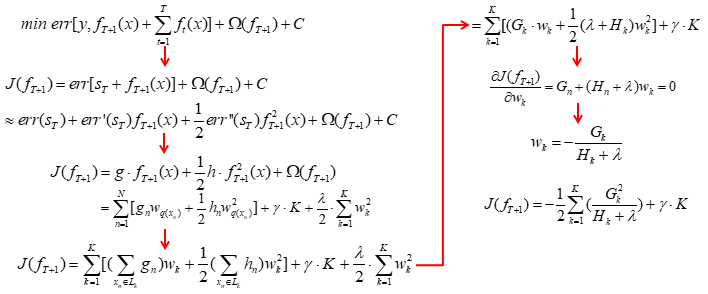

### 如何得到这样一棵树

对于一片叶子，扫描所有的划分点，选择$Gini$指数**最大**的那个作为划分点。

$Gini=不分支损失-分支损失\\
=\frac {1}{2}[(\frac{G^2_{left}}{H_{left}+\lambda})+(\frac{G^2_{right}}{H_{right}+\lambda})-(\frac{(G_{left}+G_{right})^2}{H_{left}+H_{right}+\lambda})] - \gamma
$


## 缺失值处理

